In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib.table import table
from sklearn.neighbors import KernelDensity
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import jinja2
import re
import tabulate
import ridgeplot as rg
import nbformat
from sympy import true

import seaborn as sns
import plotly.io as pio
pio.renderers.default = "notebook"
from IPython.display import IFrame
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

In [2]:
#Justin Li - Feb. 19 2026
# This is an exploratory EDA of the following variables: "CaseYear", "CrashDate","CrashSeverity", "MaxInjurySeverity","NumberOfFatalities","NumberOfInjuries","NumberOfOtherInjuries","NumberOfVehicles", "CommercialVehicleCrashInd", "isLargeTruckCrash", and if I can get to it
df = pd.read_csv("2012-24_Crash_Events.csv")
df.columns


C:\Users\AtomicArmaggedon\AppData\Local\Temp\ipykernel_26532\1922831206.py:3: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['CaseNumber', 'CaseYear', 'CrashDate', 'CrashTime',
       'CrashTimeFormatted', 'CrashTypeCde', 'CrashType', 'CollisionType',
       'CrashSeverity', 'LightCondition', 'WeatherCondition',
       'RoadwayAccessControlCde', 'RoadwayCharacteristic',
       'RoadSurfaceCondition', 'TrafficControl', 'TrafficWay',
       'MaxInjurySeverity', 'NumberOfFatalities', 'NumberOfInjuries',
       'NumberOfSeriousInjuries', 'NumberOfOtherInjuries', 'NumberOfVehicles',
       'PoliceDept', 'ReportingAgency', 'Precinct',
       'CommercialVehicleCrashInd', 'PPDRCode', 'NonReportable',
       'ReviewedIndicator', 'DMVInsertDate', 'CountyFIPS', 'CountyName',
       'MuniFIPS', 'CityTownName', 'OnStreet', 'ClosestCrossStreet',
       'MasterIntersectionId', 'IntersectionIndicator', 'ReferenceMarker',
       'DistanceFromIntersection', 'DirectionFromIntersection', 'UTMEasting',
       'UTMNorthing', 'NonPublicWayCode', 'ACCESS_CONTROL', 'DIVIDED',
       'FUNCTIONAL_CLASS', 'MAINT_JURISDICTION_TYP

In [3]:
summary_table = df[["CaseYear", "CrashDate","CrashSeverity", "MaxInjurySeverity","NumberOfFatalities","NumberOfInjuries","NumberOfSeriousInjuries","NumberOfOtherInjuries","NumberOfVehicles", "CommercialVehicleCrashInd", "isLargeTruckCrash"]]
summary_table_sorted_year = summary_table.sort_values('CrashDate')

In [31]:
# Numeric columns
numeric_cols = [
    "NumberOfFatalities",
    "NumberOfInjuries",
    "NumberOfSeriousInjuries",
    "NumberOfOtherInjuries",
    "NumberOfVehicles"
]

numeric_summary = summary_table[numeric_cols].describe(percentiles=[.1, .25, .5, .75, .9])

# Reset index to include the statistic names
numeric_summary_reset = numeric_summary.reset_index()
numeric_summary_reset.rename(columns={"index": "Statistic"}, inplace=True)

# Format values:
formatted_data = numeric_summary_reset.copy()
for col in numeric_cols:
    formatted_data[col] = formatted_data[col].apply(
        lambda x: int(round(x)) if formatted_data.loc[formatted_data["Statistic"]=="count", col].values[0]==x else round(x, 3)
    )

# Prepare table data for reportlab
table_data = [formatted_data.columns.tolist()] + formatted_data.values.tolist()

# Save as PDF
pdf_file = "Numeric_Summary_Formatted.pdf"
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
elements = []

styles = getSampleStyleSheet()
title = Paragraph("Summary Statistics of Numeric Variables", styles['Heading2'])
elements.append(title)
elements.append(Spacer(1, 12))

# Create table
table = Table(table_data, repeatRows=1)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.darkblue),
    ('TEXTCOLOR', (0,0), (-1,0), colors.white),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('FONTSIZE', (0,0), (-1,-1), 8),
    ('BOTTOMPADDING', (0,0), (-1,0), 6),
    ('GRID', (0,0), (-1,-1), 0.5, colors.black),
]))
elements.append(table)

doc.build(elements)

# Display inline in Jupyter
display(IFrame(pdf_file, width=600, height=300))

In [33]:
categorical_cols = [
    "CrashSeverity",
    "MaxInjurySeverity"
]

# Prepare PDF
pdf_file = "Categorical_ValueCounts.pdf"
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
elements = []

styles = getSampleStyleSheet()
title = Paragraph("Value Counts for Categorical Variables", styles['Heading2'])
elements.append(title)
elements.append(Spacer(1, 12))

# Loop through categorical columns
for col in categorical_cols:
    # Add column title
    elements.append(Paragraph(f"<b>{col}</b>", styles['Heading3']))
    
    # Compute value counts
    counts = summary_table[col].value_counts().reset_index()
    counts.columns = [col, "Count"]
    
    # Convert to table data
    table_data = [counts.columns.tolist()] + counts.values.tolist()
    
    # Create ReportLab table
    table = Table(table_data, repeatRows=1)
    table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.darkblue),
        ('TEXTCOLOR', (0,0), (-1,0), colors.white),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,-1), 8),
        ('BOTTOMPADDING', (0,0), (-1,0), 6),
        ('GRID', (0,0), (-1,-1), 0.5, colors.black),
    ]))
    
    elements.append(table)
    elements.append(Spacer(1, 12))  # Add spacing between tables

# Build PDF
doc.build(elements)

# Display inline in Jupyter
display(IFrame(pdf_file, width=600, height=400))

In [35]:
bool_cols = [
    "CommercialVehicleCrashInd",
    "isLargeTruckCrash"
]

# Compute boolean summary
boolean_summary = summary_table[bool_cols].agg(['sum', 'mean'])

# Format numeric: round sum as int, mean as 3 decimals
boolean_summary_formatted = boolean_summary.copy()
boolean_summary_formatted.loc['sum'] = boolean_summary.loc['sum'].astype(int)
boolean_summary_formatted.loc['mean'] = boolean_summary.loc['mean'].round(3)

# Reset index for table display
table_data = boolean_summary_formatted.reset_index()
table_data.rename(columns={'index':'Metric'}, inplace=True)
table_list = [table_data.columns.tolist()] + table_data.values.tolist()

# Create PDF
pdf_file = "Boolean_Summary.pdf"
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
elements = []

styles = getSampleStyleSheet()
title = Paragraph("Boolean Variable Summary", styles['Heading2'])
elements.append(title)
elements.append(Spacer(1, 12))

# Create table
table = Table(table_list, repeatRows=1)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.darkblue),
    ('TEXTCOLOR', (0,0), (-1,0), colors.white),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('FONTSIZE', (0,0), (-1,-1), 8),
    ('BOTTOMPADDING', (0,0), (-1,0), 6),
    ('GRID', (0,0), (-1,-1), 0.5, colors.black),
]))
elements.append(table)

# Build PDF
doc.build(elements)

# Display PDF inline in Jupyter
display(IFrame(pdf_file, width=400, height=200))

In [7]:
# function to quickly make summary stats of each year for non-categorical values

def yearlist (startyear,endyear):
    years=[]
    for year in range(startyear,endyear+1):
        years.append(year)
    return years
def yearstats (frame, column, years):
    yearsums = []
    yearmeans = []
    yearprops = []
    casecounts = []

    for year in years:
        frameyear = frame[frame['CaseYear'] == year]
        casecount = frameyear.shape[0]
        casecounts.append(casecount)
        yearsums.append(frameyear[column].sum())
        yearmeans.append(frameyear[column].mean())
        frameyear = frameyear[frameyear[column] > 0]
        yearprops.append(frameyear.shape[0]/casecount)
    return yearsums, yearmeans, yearprops, casecounts

def yearagg (frame, column, year):
    return frame[frame["CaseYear"] == year][column].values



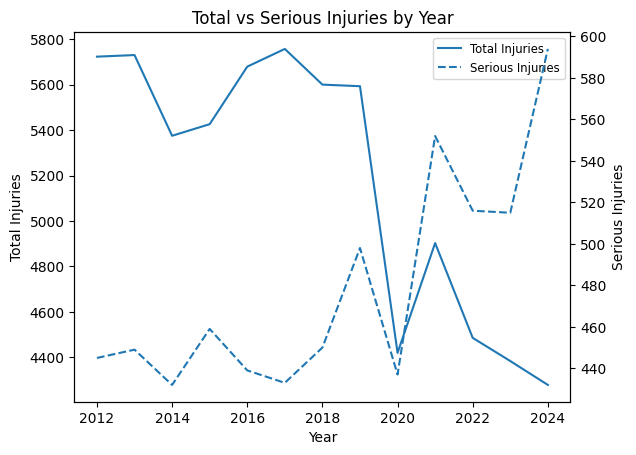

In [36]:
# Get sorted years
years = summary_table_sorted_year['CaseYear'].unique()
years.sort()

# Compute yearly stats
Injuries_yearsum, Injuries_yearmeans, Injuries_yearprops, Injuries_casecount = \
    yearstats(summary_table_sorted_year, "NumberOfInjuries", years)

SeriousInjuries_yearsum, SeriousInjuries_yearmeans, SeriousInjuries_yearprops, SeriousInjuries_casecount = \
    yearstats(summary_table_sorted_year, "NumberOfSeriousInjuries", years)

# ---------------------------------------
# Create figure and primary axis
fig, ax1 = plt.subplots()

# Primary axis → Total Injuries
line1 = ax1.plot(years, Injuries_yearsum, label="Total Injuries")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Injuries")
ax1.tick_params(axis='y')

# Secondary axis → Serious Injuries
ax2 = ax1.twinx()
line2 = ax2.plot(years, SeriousInjuries_yearsum, linestyle='--',
                 label="Serious Injuries")
ax2.set_ylabel("Serious Injuries")
ax2.tick_params(axis='y')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize='small')

plt.title("Total vs Serious Injuries by Year")

# Save figure as PDF
pdf_file = "TotalvSeriousInjuriesPYear.pdf"
plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

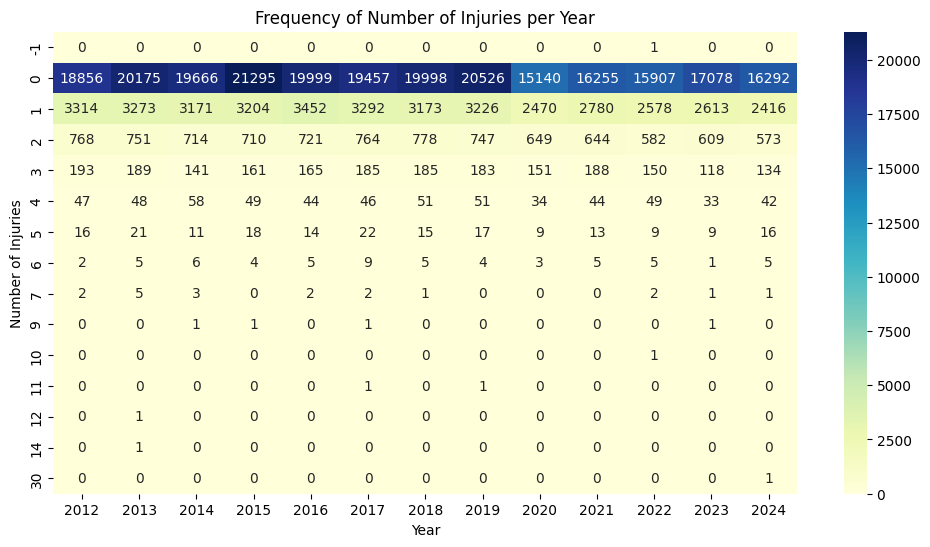

In [37]:
yearagg_injuries = []

for year in years:
    yearagg_injuries.append(yearagg(summary_table_sorted_year,"NumberOfInjuries",year))

freq_data = {}
for year, year_data in zip(years, yearagg_injuries):
    counts = pd.Series(year_data).value_counts().sort_index()
    freq_data[year] = counts

freq_table = pd.DataFrame(freq_data).fillna(0).astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(freq_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Frequency of Number of Injuries per Year")
plt.xlabel("Year")
plt.ylabel("Number of Injuries")

# Save figure as PDF
pdf_file = "NumberInjuriesPYear.pdf"
plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

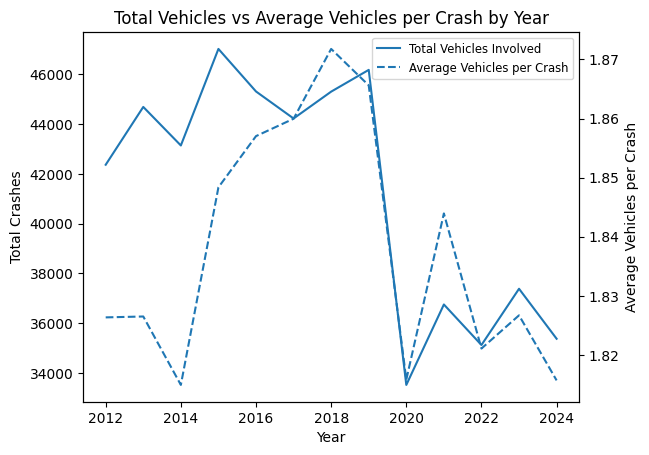

In [38]:
# Total crashes per year
_, _, _, casecounts = yearstats(summary_table_sorted_year, "CaseYear", years)

# Vehicles per crash statistics
TotalVics_yearsum, TotalVics_yearmeans, TotalVics_yearprops, TotalVics_casecount = \
    yearstats(summary_table_sorted_year, "NumberOfVehicles", years)

# -------------------------------------------------
# Create figure and primary axis
fig, ax1 = plt.subplots()

# Primary axis → Total vehicles involved
line1 = ax1.plot(years, TotalVics_yearsum, label="Total Vehicles Involved")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Crashes")

# Secondary axis → Average vehicles per crash
ax2 = ax1.twinx()

line2 = ax2.plot(years, TotalVics_yearmeans, linestyle='--',
                 label="Average Vehicles per Crash")

ax2.set_ylabel("Average Vehicles per Crash")

# -------------------------------------------------
# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize='small')

plt.title("Total Vehicles vs Average Vehicles per Crash by Year")

# Save figure as PDF
pdf_file = "TotalvAverageVehiclesPCrashPYear.pdf"
plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

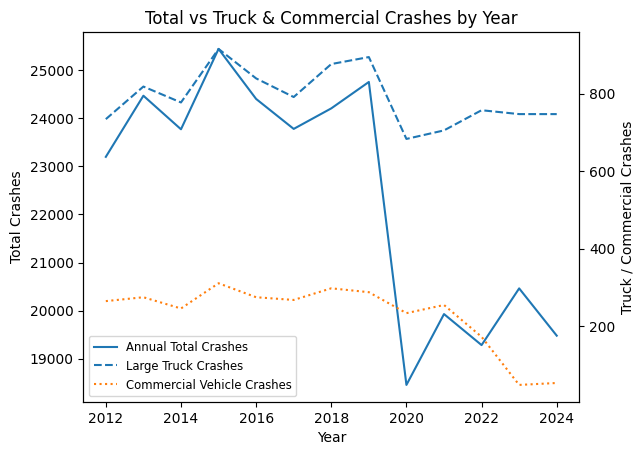

In [39]:
# Total crashes per year
_, _, _, casecounts = yearstats(summary_table_sorted_year, "CaseYear", years)

# Boolean crash types
Truck_yearsum, Truck_yearmeans, Truck_yearprops, Truck_yearcounts = \
    yearstats(summary_table_sorted_year, "isLargeTruckCrash", years)

Comm_yearsum, Comm_yearmeans, Comm_yearprops, Comm_yearcounts = \
    yearstats(summary_table_sorted_year, "CommercialVehicleCrashInd", years)

# -------------------------------------------------
# Create figure and primary axis
fig, ax1 = plt.subplots()

# Primary axis → Total crashes
line1 = ax1.plot(years, casecounts, label="Annual Total Crashes")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Crashes")

# Secondary axis → Truck & Commercial crashes
ax2 = ax1.twinx()

line2 = ax2.plot(years, Truck_yearsum, linestyle='--',
                 label="Large Truck Crashes")

line3 = ax2.plot(years, Comm_yearsum, linestyle=':',
                 label="Commercial Vehicle Crashes")

ax2.set_ylabel("Truck / Commercial Crashes")

# -------------------------------------------------
# Combine legends
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize='small')

plt.title("Total vs Truck & Commercial Crashes by Year")

# Save figure as PDF
pdf_file = "TotalvTruckCommercialPYear.pdf"
plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

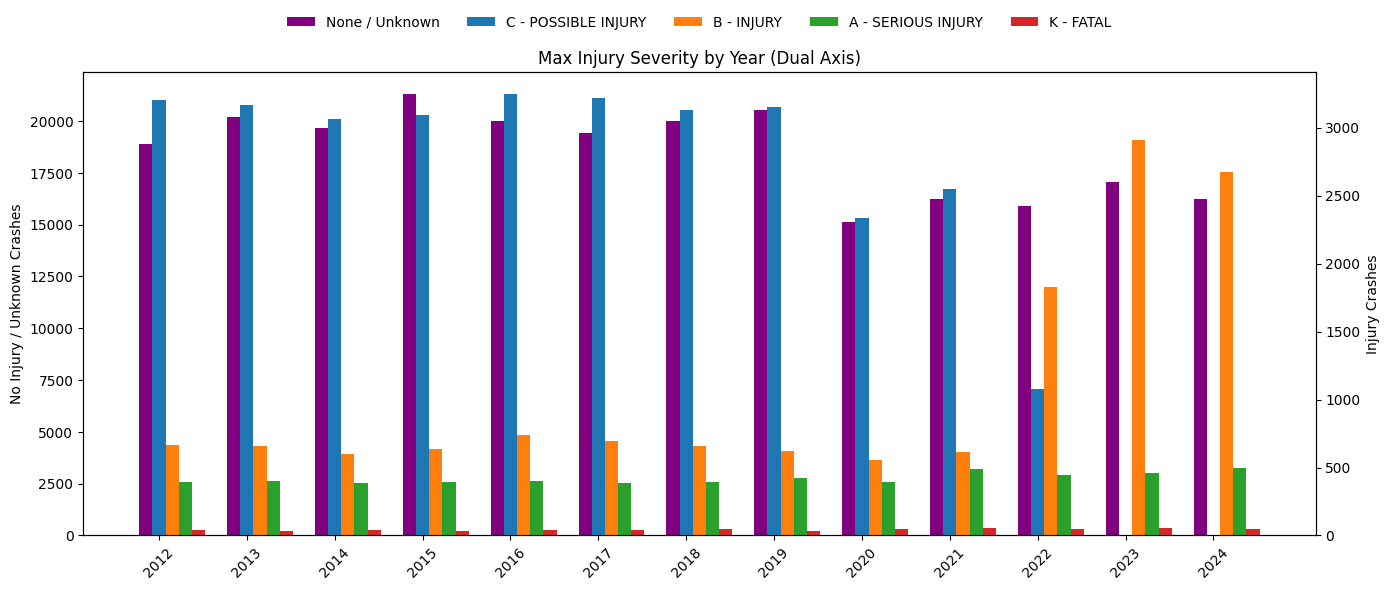

In [40]:
# Replace Unknown with None
summary_table_sorted_year['MaxInjurySeverity'] = (
    summary_table_sorted_year['MaxInjurySeverity']
    .replace("U - UNKNOWN", "None")
)

maxinjuries = summary_table_sorted_year['MaxInjurySeverity'].unique()

primary_category = "None"
secondary_categories = [cat for cat in maxinjuries if cat != primary_category]

x = np.arange(len(years))

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

width = 0.15

# ---- PRIMARY AXIS (None / Unknown) ----
none_counts = [
    summary_table_sorted_year[
        (summary_table_sorted_year["CaseYear"] == year) &
        (summary_table_sorted_year["MaxInjurySeverity"] == primary_category)
    ]["MaxInjurySeverity"].count()
    for year in years
]

ax1.bar(
    x - width,
    none_counts,
    width,
    label="None / Unknown",
    color="purple"     # ← Purple as requested
)

ax1.set_ylabel("No Injury / Unknown Crashes")

# ---- SECONDARY AXIS (Actual Injuries) ----
for i, category in enumerate(secondary_categories):
    
    counts = [
        summary_table_sorted_year[
            (summary_table_sorted_year["CaseYear"] == year) &
            (summary_table_sorted_year["MaxInjurySeverity"] == category)
        ]["MaxInjurySeverity"].count()
        for year in years
    ]
    
    ax2.bar(
        x + (i * width),
        counts,
        width,
        label=category
    )

ax2.set_ylabel("Injury Crashes")

# Formatting
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=45)
ax1.set_title("Max Injury Severity by Year (Dual Axis)")

# ---- HORIZONTAL LEGEND ABOVE PLOT ----
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),  # push above plot
    ncol=len(labels1 + labels2), # stretch horizontally
    frameon=False
)

plt.tight_layout()

# Save figure as PDF
pdf_file = "MaxInjurySeverityPYear.pdf"
plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()

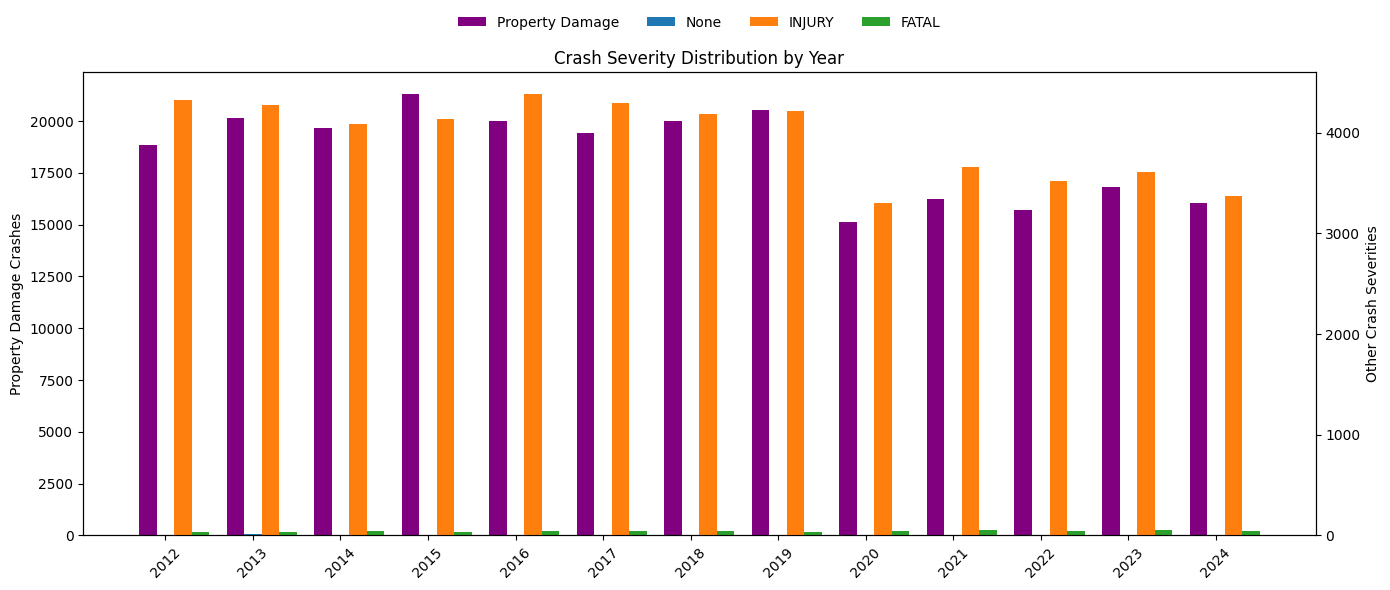

In [42]:
# Clean up categories
summary_table_sorted_year['CrashSeverity'] = summary_table_sorted_year['CrashSeverity'].fillna("None")

# Define categories
primary_category = "PROPERTY DAMAGE"  # now on primary axis
secondary_categories = ["None", "INJURY", "FATAL"]  # all other categories on secondary axis

x = np.arange(len(years))
width = 0.2

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()  # secondary y-axis

# ---- PRIMARY AXIS: Property Damage ----
primary_counts = [
    summary_table_sorted_year[
        (summary_table_sorted_year["CaseYear"] == year) &
        (summary_table_sorted_year["CrashSeverity"] == primary_category)
    ]["CrashSeverity"].count()
    for year in years
]

ax1.bar(
    x - width,
    primary_counts,
    width,
    label="Property Damage",
    color="purple"
)
ax1.set_ylabel("Property Damage Crashes")

# ---- SECONDARY AXIS: Other Severities ----
for i, category in enumerate(secondary_categories):
    counts = [
        summary_table_sorted_year[
            (summary_table_sorted_year["CaseYear"] == year) &
            (summary_table_sorted_year["CrashSeverity"] == category)
        ]["CrashSeverity"].count()
        for year in years
    ]
    
    ax2.bar(
        x + (i * width),  # position
        counts,
        width,
        label=category      # no color parameter
    )

ax2.set_ylabel("Other Crash Severities")

# Formatting
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=45)
ax1.set_title("Crash Severity Distribution by Year")

# ---- HORIZONTAL LEGEND ABOVE PLOT ----
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),  # above the chart
    ncol=len(labels1 + labels2),  # stretch horizontally
    frameon=False
)

plt.tight_layout()

# Save figure as PDF
pdf_file = "CrashSeverityPYear.pdf"
plt.savefig(pdf_file, bbox_inches='tight')  # tight layout to fit table nicely
plt.show()